# Example 3: Account for the n(z) of sources
## Fit halo mass to shear profile accounting for the redshift distribution of source galaxies

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster when source galaxies follow a given distribution (the Chang et al. (2013) implemented in `clmm`). It uses several functionalities of the support `mock_data` module to produce mock datasets.

- Setting things up, with the proper imports.
- Generating 2 datasets: an ideal dataset with source galaxies following the Chang et al. (2013) redshift distribution; a noisy dataset where photoz errors and shape noise are also included. 
- Computing the binned reduced tangential shear profile, for the 2 datasets, using logarithmic binning.
- Setting up the "single source plane" model (model1) and a model accounting for the redshift distribution (model2). As already seen in Example2, model1 will yield a biased mass reconstruction. Accounting for the redshift distribution in the model (model2) solves that issue. 
- We also add two models using the methods (to use the statistics of angular diameter distance ratio) from Applegate et al. (2014) and from Schrabback et al. (2018) respectively.
- Perform a simple fit using `scipy.optimize.curve_fit` and visualize the results.

## Setup

First, we import some standard packages.

In [1]:
# Note: Remember to run "python setup.py install --user" and select "conda-clmmenv".

import clmm
import matplotlib.pyplot as plt
import numpy as np
from astropy import units

clmm.__version__

'1.12.0'

Next, we import `clmm`'s core modules.

In [2]:
import clmm.dataops as da
import clmm.galaxycluster as gc
import clmm.theory as theory
from clmm import Cosmology

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

## Making mock data

In [3]:
from clmm.support import mock_data as mock

For reproducibility:

In [4]:
np.random.seed(11)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [5]:
cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

We now set some parameters for a mock galaxy cluster:

In [6]:
cluster_m = 1.0e15  # M200,m [Msun]
logm = np.log(cluster_m) / np.log(10)
concentration = 4
cluster_ra = 20.0
cluster_dec = 90.0
cluster_z = 0.4
ngals = 10000

Then we use the `mock_data` support module to generate 2 galaxy catalogs:
- `ideal_data`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data`: `ideal_data` + photoz errors + shape noise

(Galaxies have a minimum redshift defined as $z_{cluster} + 0.1$)

In [7]:
ideal_data = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    concentration,
    cosmo,
    "chang13",
    zsrc_min=cluster_z + 0.1,
    ngals=ngals,
    cluster_ra=cluster_ra,
    cluster_dec=cluster_dec,
)
noisy_data = mock.generate_galaxy_catalog(
    cluster_m,
    cluster_z,
    concentration,
    cosmo,
    "chang13",
    zsrc_min=cluster_z + 0.1,
    shapenoise=0.05,
    photoz_sigma_unscaled=0.05,
    ngals=ngals,
    cluster_ra=cluster_ra,
    cluster_dec=cluster_dec,
)

The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [8]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, ideal_data)
gc_object.save("ideal_GC.pkl")

cluster_id = "CL_noisy"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, noisy_data)
gc_object.save("noisy_GC.pkl")

Any saved clmm.GalaxyCluster object may be read in for analysis.

In [9]:
cl_ideal = clmm.GalaxyCluster.load(
    "ideal_GC.pkl"
)  # background galaxies distributed according to Chang et al. (2013)
cl_noisy = clmm.GalaxyCluster.load("noisy_GC.pkl")  # Chang et al. (2013) + shapenoise + photozerror

### Redshift of galaxies generated by mock data are distributed following the Chang et al. (2013) redshift distribution.

(0.0, 5.0)

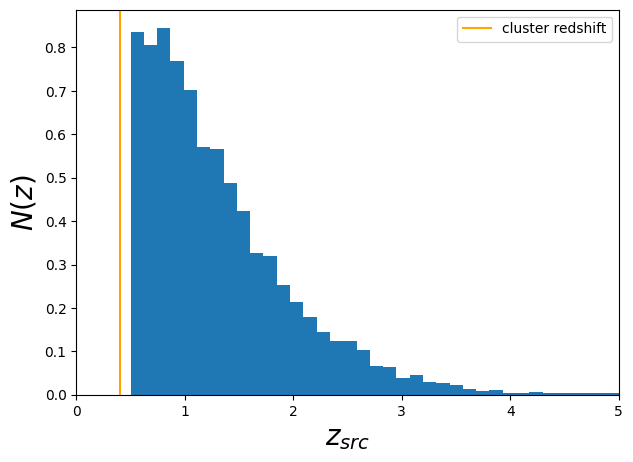

In [10]:
plt.figure(figsize=(7, 5))
plt.hist(cl_ideal.galcat["z"], density=True, bins=50)
plt.axvline(x=cluster_z, color="orange", label="cluster redshift")
plt.xlabel(r"$z_{src}$", fontsize=20)
plt.ylabel(r"$N(z$)", fontsize=20)
plt.legend()
plt.xlim(0, 5)

## Deriving observables

### Computing shear

`clmm.GalaxyCluster.compute_tangential_and_cross_components` calculates the tangential and cross shears for each source galaxy in the cluster.

In [11]:
# We can add geometry="flat" as an argument; the current default is the "curve" geometry from astropy.
cl_ideal.compute_tangential_and_cross_components()
cl_noisy.compute_tangential_and_cross_components()
pass

### Radially binning the data

In [12]:
bin_edges = da.make_bins(0.2, 4, 15, method="evenlog10width")

`clmm.GalaxyCluster.make_radial_profile` evaluates the average shear of the galaxy catalog in bins of radius.
Note the source redshifts are also binned -- so in the radial profile (table) each z value is the mean in that radial bin (details in `clmm/dataops/__init__.py: make_radial_profile()` and `clmm/utils.py: compute_radial_averages()`).

In [13]:
cl_ideal.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo, gal_ids_in_bins=True)
cl_noisy.make_radial_profile("Mpc", bins=bin_edges, cosmo=cosmo, gal_ids_in_bins=True)
pass

After this, the object acquires the `clmm.GalaxyCluster.profile` attribute.

## Create the reduced tangential shear models

We consider three options:
- First, the naive and *wrong* approach: the reduced tangential shear in a given radial bin $j$ is given by $g_t(\theta_j, \langle z_s \rangle)$, where $\langle z_s \rangle$ is the average redshift in the bin. In that case, the corresponding model is simply given by the function below:

In [14]:
def model_reduced_tangential_shear_singlez(r, logm, z_src):
    m = 10.0**logm
    gt_model = clmm.compute_reduced_tangential_shear(
        r, m, concentration, cluster_z, z_src, cosmo, delta_mdef=200, halo_profile_model="nfw"
    )
    return gt_model

- Second, the reduced tangential shear in a given radial bin accounts properly for the redshift distribution in the bin as $\langle g_t(\theta_j, z_s)\rangle \neq g_t(\theta_j, \langle z_s \rangle$). Formally, the reduced tangential shear that corresponds to a continuous distribution of source galaxy redshift $N(z)$ can be expressed as:

$$
g_t(\theta) = \langle g_t(\theta, z_s)\rangle_{z_{cluster}} = \int_{z_{cluster}}^{+\infty}dz_sN(z_s)g_t(\theta, z_s)
$$

If the inidividual redshifts of the background galaxies are known, we can directly build a model based on data, such that in the bin $j$: 

$$
g_t(\theta_j) = \frac{1}{N(\theta_j)}\sum\limits_{i = 1}^{N(\theta)}g_t(\theta_j, z_i)
$$

where $N(\theta_j)$ is the number of galaxies in bin $j$. The corresponding model is given below.

In [ ]:
def model_reduced_tangential_shear_zdistrib(radius, logm, catalog, profile):
    m = 10**logm
    gt_model = []
    for i in range(len(radius)):
        r = profile["radius"][i]
        galist = profile["gal_id"][i]
        z_list = catalog.galcat["z"][galist]
        shear = clmm.compute_reduced_tangential_shear(
            r, m, concentration, cluster_z, z_list, cosmo, delta_mdef=200, halo_profile_model="nfw"
        )
        gt_model.append(np.mean(shear))

    return gt_model

- Third, we consider two models that use the statistics of angular diameter distance ratio ($\beta_s$, i.e. $\langle\beta_s\rangle$, $\langle\beta^2_s\rangle>$). They are similar to the ones we showed in the notebook for paper v1.0 (`gt_and_use_case.ipynb`) and the notebook for real data (Example4).

In [ ]:
# We define two (reduced) shear estimates by using the statistics of beta_s.
# We expect the results will be close to the second method above.

# Here beta_s are calculated inside these functions using the distribution in Chang et al. (2013).
# But beta_s_mean and beta_s_square_mean can also be given from outside.
# See details in these scripts below.
# clmm/theory/func_layer.py: compute_reduced_tangential_shear()
# clmm/theory/parent_class.py: eval_reduced_tangential_shear()

# The method from Applegate et al. (2014), called 'order1' in CLMM.
# The argument "profile" is only used to get the radius values r = profile['radius']
# The default mass is M200m; use massdef='critical' for M200c.


def _model_reduced_tangential_shear(logm, catalog, profile, approx):
    beta_kwargs = {
        "z_cl": cluster_z,
        "z_inf": 10.0,
        "cosmo": cosmo,
        #'zmax' :zsrc_max,
        #'delta_z_cut': delta_z_cut,
        #'zmin': None,
        # We provide the redshift distribution (default: Chang et al. 2013) for calculating the beta_s statistics
        "z_distrib_func": clmm.redshift.distributions.chang2013,
    }
    beta_s_mean = clmm.utils.compute_beta_s_mean_from_distribution(**beta_kwargs)
    beta_s_square_mean = clmm.utils.compute_beta_s_square_mean_from_distribution(**beta_kwargs)

    gt_model = clmm.compute_reduced_tangential_shear(
        r_proj=profile["radius"],  # Radial component of the profile
        mdelta=10**logm,  # Mass of the cluster [M_sun]
        cdelta=concentration,  # Concentration of the cluster
        z_cluster=cluster_z,  # Redshift of the cluster
        z_src=[beta_s_mean, beta_s_square_mean],
        cosmo=cosmo,
        delta_mdef=200,
        # massdef='critical',
        halo_profile_model="nfw",
        z_src_info="beta",
        approx=approx,
        # beta_s_mean=None,
        # beta_s_square_mean=None
    )
    return gt_model


def model_reduced_tangential_shear_applegate14(logm, catalog, profile):
    return _model_reduced_tangential_shear(logm, catalog, profile, approx="order1")


# Similarly, we also consider the method from Schrabback et al. (2018), called 'order2' in CLMM.
def model_reduced_tangential_shear_schrabback18(logm, catalog, profile):
    return _model_reduced_tangential_shear(logm, catalog, profile, approx="order2")

### Before fitting, let's first vizualise these models using the known true mass

In [ ]:
logm = np.log10(cluster_m)
r = cl_ideal.profile["radius"]

gt_model_ideal_singlez = model_reduced_tangential_shear_singlez(r, logm, cl_ideal.profile["z"])
gt_model_ideal_zdistrib = model_reduced_tangential_shear_zdistrib(
    r, logm, cl_ideal, cl_ideal.profile
)
gt_model_ideal_applegate14 = model_reduced_tangential_shear_applegate14(
    logm, cl_ideal, cl_ideal.profile
)
gt_model_ideal_schrabback18 = model_reduced_tangential_shear_schrabback18(
    logm, cl_ideal, cl_ideal.profile
)

# Noisy data can have some source redshifts that are lower than the cluster redshift.
gt_model_noisy_singlez = model_reduced_tangential_shear_singlez(r, logm, cl_noisy.profile["z"])
gt_model_noisy_zdistrib = model_reduced_tangential_shear_zdistrib(
    r, logm, cl_noisy, cl_noisy.profile
)
gt_model_noisy_applegate14 = model_reduced_tangential_shear_applegate14(
    logm, cl_noisy, cl_noisy.profile
)
gt_model_noisy_schrabback18 = model_reduced_tangential_shear_schrabback18(
    logm, cl_noisy, cl_noisy.profile
)

In [ ]:
# The blue solid curve and red/green dotted curves are expected to be close (especially when g is small, i.e., large radii).
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)

plt.title("ideal data", fontsize=20)
plt.errorbar(
    r,
    cl_ideal.profile["gt"],
    cl_ideal.profile["gt_err"],
    c="k",
    linestyle="",
    marker="o",
    label=r"ideal data, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_ideal_zdistrib,
    "-b",
    label=r"w/ zdistrib, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_ideal_singlez,
    "-y",
    label=r"w/o zdistrib, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_ideal_applegate14,
    ":r",
    label=r"applegate14, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_ideal_schrabback18,
    ":g",
    label=r"schrabback18, $M_{input}$ = %.2e Msun" % cluster_m,
)

plt.xlabel("r [Mpc]", fontsize=20)
plt.ylabel(r"$g_t$", fontsize=20)
plt.xlim(min(cl_ideal.profile["radius"]), max(cl_ideal.profile["radius"]))
plt.legend(fontsize=15)


plt.subplot(1, 2, 2)

plt.title("noisy data", fontsize=20)
plt.errorbar(
    r,
    cl_noisy.profile["gt"],
    cl_noisy.profile["gt_err"],
    c="k",
    linestyle="",
    marker="o",
    label=r"noisy data, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_noisy_zdistrib,
    "-b",
    label=r"w/ zdistrib, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_noisy_singlez,
    "-y",
    label=r"w/o zdistrib, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_noisy_applegate14,
    ":r",
    label=r"applegate14, $M_{input}$ = %.2e Msun" % cluster_m,
)
plt.loglog(
    r,
    gt_model_noisy_schrabback18,
    ":g",
    label=r"schrabback18, $M_{input}$ = %.2e Msun" % cluster_m,
)

plt.xlabel("r [Mpc]", fontsize=20)
plt.ylabel(r"$g_t$", fontsize=20)
plt.xlim(min(cl_noisy.profile["radius"]), max(cl_noisy.profile["radius"]))
plt.legend(fontsize=15)

The naive model that uses the average redshift in the bin clearly does not give the right description of the ideal data (left panel), and will yield biased mass results if used for fitting (see below). For ideal data, the model that accounts for the redshift distribution is, by construction, an excellent description of the data (solid blue line). The same is true for noisy data (right panel), although the noise make the naive model appear "less biased". 
The models from Applegate et al. (2014) and Schrabback et al. (2018) give close results to the input data for both ideal and noisy data. 

## Mass fitting

We estimate the best-fit mass using `scipy.optimize.curve_fit`.  We compare estimated mass for noisy and ideal data, using all models described above (naive with average redshift or the model taking into account the redshift distribution, and also the ones using $\beta_s$). The choice of fitting $\log_{10} M$ instead of $M$ lowers the range of pre-defined fitting bounds from several order of magnitude for the mass to unity. From the associated error $\Delta (\log_{10}M)$ we calculate the error to mass as $\Delta M = M_{fit}\log(10)\Delta (\log_{10}M)$.

In [ ]:
from clmm.support.sampler import fitters

In [ ]:
popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_zdistrib(r, logm, cl_ideal, cl_ideal.profile),
    cl_ideal.profile["radius"],
    cl_ideal.profile["gt"],
    cl_ideal.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_ideal_zdistrib = 10.0 ** popt[0]
m_est_err_ideal_zdistrib = m_est_ideal_zdistrib * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_applegate14(logm, cl_ideal, cl_ideal.profile),
    cl_ideal.profile["radius"],
    cl_ideal.profile["gt"],
    cl_ideal.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_ideal_applegate14 = 10.0 ** popt[0]
m_est_err_ideal_applegate14 = m_est_ideal_applegate14 * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_schrabback18(logm, cl_ideal, cl_ideal.profile),
    cl_ideal.profile["radius"],
    cl_ideal.profile["gt"],
    cl_ideal.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_ideal_schrabback18 = 10.0 ** popt[0]
m_est_err_ideal_schrabback18 = m_est_ideal_schrabback18 * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_singlez(r, logm, cl_ideal.profile["z"]),
    cl_ideal.profile["radius"],
    cl_ideal.profile["gt"],
    cl_ideal.profile["gt_err"],
    bounds=[10.0, 17.0],
)

m_est_ideal_singlez = 10.0 ** popt[0]
m_est_err_ideal_singlez = m_est_ideal_singlez * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_zdistrib(r, logm, cl_noisy, cl_noisy.profile),
    cl_noisy.profile["radius"],
    cl_noisy.profile["gt"],
    cl_noisy.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_noisy_zdistrib = 10.0 ** popt[0]
m_est_err_noisy_zdistrib = m_est_noisy_zdistrib * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_applegate14(logm, cl_noisy, cl_noisy.profile),
    cl_noisy.profile["radius"],
    cl_noisy.profile["gt"],
    cl_noisy.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_noisy_applegate14 = 10.0 ** popt[0]
m_est_err_noisy_applegate14 = m_est_noisy_applegate14 * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_schrabback18(logm, cl_noisy, cl_noisy.profile),
    cl_noisy.profile["radius"],
    cl_noisy.profile["gt"],
    cl_noisy.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_noisy_schrabback18 = 10.0 ** popt[0]
m_est_err_noisy_schrabback18 = m_est_noisy_schrabback18 * np.sqrt(pcov[0][0]) * np.log(10)


popt, pcov = fitters["curve_fit"](
    lambda r, logm: model_reduced_tangential_shear_singlez(r, logm, cl_noisy.profile["z"]),
    cl_noisy.profile["radius"],
    cl_noisy.profile["gt"],
    cl_noisy.profile["gt_err"],
    bounds=[10.0, 16.0],
)

m_est_noisy_singlez = 10.0 ** popt[0]
m_est_err_noisy_singlez = m_est_noisy_singlez * np.sqrt(pcov[0][0]) * np.log(10)

In [ ]:
print(f"The input mass = {cluster_m:.2e} Msun\n")

_prt_mfit = lambda mass, mass_err: f"{mass*1e-14:.2f} +/- {mass_err*1e-14:.2f} x 10^14 Msun"

print("Without accounting for the redshift distribution in the model\n")
print(f"Best fit mass for ideal data = {_prt_mfit(m_est_ideal_singlez, m_est_err_ideal_singlez)}")
print(f"Best fit mass for noisy data = {_prt_mfit(m_est_noisy_singlez, m_est_err_noisy_singlez)}\n")

print("Accounting for the redshift distribution in the model\n")
print(f"Best fit mass for ideal data = {_prt_mfit(m_est_ideal_zdistrib, m_est_err_ideal_zdistrib)}")
print(
    f"Best fit mass for noisy data = {_prt_mfit(m_est_noisy_zdistrib, m_est_err_noisy_zdistrib)}\n"
)

print("Using applegate14 (Applegate et al. 2014)\n")
print(
    f"Best fit mass for ideal data = {_prt_mfit(m_est_ideal_applegate14, m_est_err_ideal_applegate14)}"
)
print(
    f"Best fit mass for noisy data = {_prt_mfit(m_est_noisy_applegate14, m_est_err_noisy_applegate14)}\n"
)

print("Using schrabback18 (Schrabback et al. 2018)\n")
print(
    f"Best fit mass for ideal data = {_prt_mfit(m_est_ideal_schrabback18, m_est_err_ideal_schrabback18)}"
)
print(
    f"Best fit mass for noisy data = {_prt_mfit(m_est_noisy_schrabback18, m_est_err_noisy_schrabback18)}\n"
)

As expected, the reconstructed mass is biased when the redshift distribution is not accounted for in the model; the method of applegate14 (Applegate et al. 2014) and the method of schrabback18 (Schrabback et al. 2018) give close results to the one that accounts for the redshift distribution (and to the input mass).

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the models with estimated masses for noisy and ideal data.

In [ ]:
gt_est_ideal_zdistrib = model_reduced_tangential_shear_zdistrib(
    r, np.log(m_est_ideal_zdistrib) / np.log(10), cl_ideal, cl_ideal.profile
)
gt_est_noisy_zdistrib = model_reduced_tangential_shear_zdistrib(
    r, np.log(m_est_noisy_zdistrib) / np.log(10), cl_noisy, cl_noisy.profile
)
gt_est_ideal_applegate14 = model_reduced_tangential_shear_applegate14(
    np.log(m_est_ideal_applegate14) / np.log(10), cl_ideal, cl_ideal.profile
)
gt_est_noisy_applegate14 = model_reduced_tangential_shear_applegate14(
    np.log(m_est_noisy_applegate14) / np.log(10), cl_noisy, cl_noisy.profile
)
gt_est_ideal_schrabback18 = model_reduced_tangential_shear_schrabback18(
    np.log(m_est_ideal_schrabback18) / np.log(10), cl_ideal, cl_ideal.profile
)
gt_est_noisy_schrabback18 = model_reduced_tangential_shear_schrabback18(
    np.log(m_est_noisy_schrabback18) / np.log(10), cl_noisy, cl_noisy.profile
)

gt_est_ideal_singlez = model_reduced_tangential_shear_singlez(
    r, np.log(m_est_ideal_singlez) / np.log(10), cl_ideal.profile["z"]
)
gt_est_noisy_singlez = model_reduced_tangential_shear_singlez(
    r, np.log(m_est_noisy_singlez) / np.log(10), cl_noisy.profile["z"]
)

We compare to tangential shear obtained with theoretical mass. We plot the reduced tangential shear models first when redshift distribution is accounted for in the model (and the ones using $\beta_s$) then for the naive approach, with respective best-fit masses.

In [ ]:
_prt_mfit_lab = (
    lambda mass, mass_err: rf"${mass*1e-14:.2f} (\pm {mass_err*1e-14:.2f}) \times 10^{{14}}$ $M_\odot$"
)

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title(r"tangential shear $g_t$ (ideal data)", fontsize=20)
plt.errorbar(
    r,
    cl_ideal.profile["gt"],
    cl_ideal.profile["gt_err"],
    c="k",
    linestyle="",
    marker="o",
    label=rf"ideal data, $M_{{input}}$ = ${cluster_m*1e-14:.2f} \times 10^{{14}}$ $M_\odot$",
)
plt.loglog(
    r,
    gt_est_ideal_zdistrib,
    "-b",
    label=rf"w/ zdistrib, M_fit = {_prt_mfit_lab(m_est_ideal_zdistrib, m_est_err_ideal_zdistrib)}",
)
plt.loglog(
    r,
    gt_est_ideal_applegate14,
    ":r",
    label=rf"applegate14, M_fit = {_prt_mfit_lab(m_est_ideal_applegate14, m_est_err_ideal_applegate14)}",
)
plt.loglog(
    r,
    gt_est_ideal_schrabback18,
    ":g",
    label=rf"schrabback18, M_fit = {_prt_mfit_lab(m_est_ideal_schrabback18, m_est_err_ideal_schrabback18)}",
)
plt.loglog(
    r,
    gt_est_ideal_singlez,
    "-y",
    label=rf"w/o zdistrib, M_fit = {_prt_mfit_lab(m_est_ideal_singlez, m_est_err_ideal_singlez)}",
)

plt.xlabel("r [Mpc]", fontsize=20)
plt.ylabel(r"$g_t$", fontsize=20)
plt.xlim(min(cl_ideal.profile["radius"]), max(cl_ideal.profile["radius"]))
plt.legend(fontsize=15)


plt.subplot(1, 2, 2)
plt.title(r"tangential shear $g_t$ (noisy data)", fontsize=20)
plt.errorbar(
    r,
    cl_noisy.profile["gt"],
    cl_noisy.profile["gt_err"],
    c="k",
    linestyle="",
    marker="o",
    label=rf"noisy data, $M_{{input}}$ = ${cluster_m*1e-14:.2f} \times 10^{{14}}$ $M_\odot$",
)
# plt.loglog(r,gt_model_noisy,'-r',  label='model, $M_{input}$ = %.3e Msun' % cluster_m)
plt.loglog(
    r,
    gt_est_noisy_zdistrib,
    "-b",
    label=rf"w/ zdistrib, M_fit = {_prt_mfit_lab(m_est_noisy_zdistrib, m_est_err_noisy_zdistrib)}",
)
plt.loglog(
    r,
    gt_est_noisy_applegate14,
    ":r",
    label=rf"applegate14, M_fit = {_prt_mfit_lab(m_est_noisy_applegate14, m_est_err_noisy_applegate14)}",
)
plt.loglog(
    r,
    gt_est_noisy_schrabback18,
    ":g",
    label=rf"schrabback18, M_fit = {_prt_mfit_lab(m_est_noisy_schrabback18, m_est_err_noisy_schrabback18)}",
)
plt.loglog(
    r,
    gt_est_noisy_singlez,
    "-y",
    label=rf"w/o zdistrib, M_fit = {_prt_mfit_lab(m_est_noisy_singlez, m_est_err_noisy_singlez)}",
)

plt.xlabel("r [Mpc]", fontsize=20)
plt.ylabel(r"$g_t$", fontsize=20)
plt.xlim(min(cl_noisy.profile["radius"]), max(cl_noisy.profile["radius"]))
plt.legend(fontsize=15)

We note that the reconstruction of mass is biased when redshift distribution is not accounted for in the model, and is smaller compared to the input mass. It is associated to the increase of the reduced tangential shear with the source redshift $z_s$ for a given radius $r$. 